### About Datasets

- Context 
<span style="color: gray"><br>
This dataset deals with air pollution measurement information in Seoul, South Korea.<br>
Seoul Metropolitan Government provides many public data, including air pollution information, through the 'Open Data Plaza'.<br>
I made a structured dataset by collecting and adjusting various air pollution related datasets provided by the Seoul Metropolitan Government<br></span>
<br><br> 
- Content
<span style="color: gray"><br>
This data provides average values for six pollutants (SO2, NO2, CO, O3, PM10, PM2.5).<br>
Data were measured every hour between 2017 and 2019.<br>
Data were measured for 25 districts in Seoul.<br>
This dataset is divided into four files.<br><br>
(1) Measurement info: Air pollution measurement information<br>
    * 1 hour average measurement is provided after calibration
    * Instrument status:<br>
      \- 0: Normal, 1: Need for calibration, 2: Abnormal <br>
      \- 4: Power cut off, 8: Under repair, 9: abnormal data<br>
<br>
(2) Measurement item info: Information on air pollution measurement items<br>
(3) Measurement station info: Information on air pollution instrument stations<br>
(4) Measurement summary: A condensed dataset based on the above three data.<br>
</span>
<br><br>
- Acknowledgements
<span style="color: gray"><br>
Data is provided from here.<br>
<br>
    * https://data.seoul.go.kr/dataList/OA-15526/S/1/datasetView.do<br>
    * https://data.seoul.go.kr/dataList/OA-15516/S/1/datasetView.do<br>
    * https://data.seoul.go.kr/dataList/OA-15515/S/1/datasetView.do<br>
<span style="color: gray"><br>
Thank you to Seoul City, Seoul Open Data Plaza, and Air Quality Analysis Center for providing data.</span>
<br>  <br>  
------

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt 
#import plotly.graph_objects as go
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor


labelencoder = LabelEncoder()
%matplotlib inline

!pip install pmdarima

froot='/Users/jiwookim/Documents/graduate/수업/Machine_Learning_2022-1/Term_Project/Measurement_summary.csv'
data= pd.read_csv('./Measurement_summary.csv')
data.head()


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


,Measurement date,Station code,Address,Latitude,Longitude,SO2,NO2,O3,CO,PM10,PM2.5
0,2017-01-01 00:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.004,0.059,0.002,1.2,73.0,57.0
1,2017-01-01 01:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.004,0.058,0.002,1.2,71.0,59.0
2,2017-01-01 02:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.004,0.056,0.002,1.2,70.0,59.0
3,2017-01-01 03:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.004,0.056,0.002,1.2,70.0,58.0
4,2017-01-01 04:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.003,0.051,0.002,1.2,69.0,61.0


In [2]:
from datetime import datetime 
data['Measurement date'] = pd.to_datetime(data['Measurement date'])
data.set_index('Measurement date', drop=True, inplace=True)

##### ii. 결측치 처리 
nan value는 없지만, 대기 중 오염물질의 농도가 음수일 수 는 없으므로, -1로 결측값을 채워 놓은 것 같다.

또한, 그래프를 보아 이상치라 의심할 만 한 것들이 많지 않게 있는 것 같다. 

**처리 전략**
- 결측치 처리: 채워진 결측값을 다시 nan value
- 이상치 처리: 이상치를 탐색하고 nan value 처리 해준다.
- 보간: 처리된 nan value들을 quadratic interpolation 해주어 근사한다.


In [3]:
data.iloc[852:857,4:]

,SO2,NO2,O3,CO,PM10,PM2.5
Measurement date,,,,,,
2017-02-05 12:00:00,0.003,0.030,0.020,0.5,18.0,12.0
2017-02-05 13:00:00,0.003,0.032,0.017,0.5,22.0,16.0
2017-02-05 14:00:00,-1.000,-1.000,-1.000,-1.0,-1.0,-1.0
2017-02-05 15:00:00,-1.000,-1.000,-1.000,-1.0,-1.0,-1.0
2017-02-05 16:00:00,-1.000,-1.000,-1.000,-1.0,-1.0,-1.0


In [4]:
data.columns

Index(['Station code', 'Address', 'Latitude', 'Longitude', 'SO2', 'NO2', 'O3',
       'CO', 'PM10', 'PM2.5'],
      dtype='object')

In [5]:
raw_data=data.copy()
for col in data.columns[4:] :
  data.loc[data[col] < 0, col] = np.nan

In [6]:
data.iloc[852:857,4:]

,SO2,NO2,O3,CO,PM10,PM2.5
Measurement date,,,,,,
2017-02-05 12:00:00,0.003,0.030,0.020,0.5,18.0,12.0
2017-02-05 13:00:00,0.003,0.032,0.017,0.5,22.0,16.0
2017-02-05 14:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2017-02-05 15:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2017-02-05 16:00:00,NaN,NaN,NaN,NaN,NaN,NaN


잘 처리됨. 

##### iii. 이상치 처리
대부분 0 근처의 값을 가지고 있고, 이상치 광범위하게 이상치 분포

IQR 이용하여 outlier 정의하고 nan value 처리 해주겠음.

<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FcAqc6V%2FbtqyQLiddUd%2FiXQVu1nYTo2rx3Q8xZBqy0%2Fimg.png" width= 400>

In [7]:
for col in data.columns[4:]:

  Q1 = np.nanpercentile(data[col], 25) # nan-value 제외하고 집계
  Q3 = np.nanpercentile(data[col], 75)
  IQR = Q3 - Q1
  outlier_step = 1.5 * IQR

  # outlier_list_col= df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
  data.loc[(data[col] < Q1 - outlier_step)|(data[col] > Q3 + outlier_step), col] = np.nan



##### iV. NaN value 보간

In [8]:
itp_data=data.copy()
itp_data.head(1)

,Station code,Address,Latitude,Longitude,SO2,NO2,O3,CO,PM10,PM2.5
Measurement date,,,,,,,,,,
2017-01-01,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.004,0.059,0.002,NaN,73.0,57.0


In [9]:
# 결측치 spline 보간
for col in itp_data.columns[4:]: 
  col_new= itp_data[col].interpolate(method='time')

  itp_data[col]=col_new

itp_data.describe()

,Station code,Latitude,Longitude,SO2,NO2,O3,CO,PM10,PM2.5
count,647511.000000,647511.000000,647511.000000,647511.000000,647511.000000,647511.000000,647504.000000,647511.000000,647511.000000
mean,113.000221,37.553484,126.989340,0.004193,0.028067,0.023653,0.496038,38.904256,22.152699
std,7.211315,0.053273,0.078790,0.001525,0.015340,0.017679,0.204423,23.144889,14.526268
min,101.000000,37.452357,126.835151,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,107.000000,37.517528,126.927102,0.003000,0.016000,0.009000,0.300000,22.000000,11.000000
50%,113.000000,37.544962,127.004850,0.004000,0.025000,0.021000,0.500000,35.000000,19.000000
75%,119.000000,37.584848,127.047470,0.005000,0.038000,0.034000,0.600000,52.000000,30.000000
max,125.000000,37.658774,127.136792,0.008000,0.071000,0.074000,1.000000,99.000000,61.000000


In [10]:
itp_data.iloc[852:857, 4:]

,SO2,NO2,O3,CO,PM10,PM2.5
Measurement date,,,,,,
2017-02-05 12:00:00,0.003,0.030,0.020,0.5,18.0,12.0
2017-02-05 13:00:00,0.003,0.032,0.017,0.5,22.0,16.0
2017-02-05 14:00:00,0.003,0.031,0.017,0.4,17.0,9.0
2017-02-05 15:00:00,0.004,0.028,0.018,0.4,20.0,9.0
2017-02-05 16:00:00,0.004,0.029,0.027,0.6,16.0,17.0


결측치 때 nan-value 처리하고 확인했을 때와 동일한 time stamp의 데이터를 보았을 때 얼추 잘 보간 된 것 같다. 

In [11]:
# data.set_index('Measurement date', drop=True, inplace= True)
itp_data.head(10)

,Station code,Address,Latitude,Longitude,SO2,NO2,O3,CO,PM10,PM2.5
Measurement date,,,,,,,,,,
2017-01-01 00:00:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.004,0.059,0.002,NaN,73.0,57.0
2017-01-01 01:00:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.004,0.058,0.002,NaN,71.0,59.0
2017-01-01 02:00:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.004,0.056,0.002,NaN,70.0,59.0
2017-01-01 03:00:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.004,0.056,0.002,NaN,70.0,58.0
2017-01-01 04:00:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.003,0.051,0.002,NaN,69.0,61.0
2017-01-01 05:00:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.003,0.046,0.002,NaN,70.0,61.0
2017-01-01 06:00:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.003,0.049,0.002,NaN,66.0,57.0
2017-01-01 07:00:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.003,0.045,0.002,1.0,71.0,60.0
2017-01-01 08:00:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.004,0.047,0.002,1.0,72.0,60.0


In [12]:
itp_data.isna().sum()

Station code    0
Address         0
Latitude        0
Longitude       0
SO2             0
NO2             0
O3              0
CO              7
PM10            0
PM2.5           0
dtype: int64

In [13]:
# CO 0~7번 데이터는 보간이 안된다...<ㅠ
# NOCB 하겠음

itp_data.iloc[:8, 7]=itp_data.iloc[8,7]
itp_data.head(10)

,Station code,Address,Latitude,Longitude,SO2,NO2,O3,CO,PM10,PM2.5
Measurement date,,,,,,,,,,
2017-01-01 00:00:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.004,0.059,0.002,1.0,73.0,57.0
2017-01-01 01:00:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.004,0.058,0.002,1.0,71.0,59.0
2017-01-01 02:00:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.004,0.056,0.002,1.0,70.0,59.0
2017-01-01 03:00:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.004,0.056,0.002,1.0,70.0,58.0
2017-01-01 04:00:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.003,0.051,0.002,1.0,69.0,61.0
2017-01-01 05:00:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.003,0.046,0.002,1.0,70.0,61.0
2017-01-01 06:00:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.003,0.049,0.002,1.0,66.0,57.0
2017-01-01 07:00:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.003,0.045,0.002,1.0,71.0,60.0
2017-01-01 08:00:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.004,0.047,0.002,1.0,72.0,60.0


preprocessig of null, nan, missing value(<0) 

In [14]:
O3df= itp_data.loc[:,[ 'Station code','O3']] #필요정보만 추출
O3df.head()

,Station code,O3
Measurement date,,
2017-01-01 00:00:00,101,0.002
2017-01-01 01:00:00,101,0.002
2017-01-01 02:00:00,101,0.002
2017-01-01 03:00:00,101,0.002
2017-01-01 04:00:00,101,0.002


In [15]:
#check Null
O3df.info() 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 647511 entries, 2017-01-01 00:00:00 to 2019-12-31 23:00:00
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Station code  647511 non-null  int64  
 1   O3            647511 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 14.8 MB


In [16]:
fstation='/Users/jiwookim/Library/Mobile Documents/com~apple~CloudDocs/Documents/Lecture/Machine_Learning_2022-1/Term_Project/Measurement_station_info.csv'
station_info= pd.read_csv('./Measurement_station_info.csv')
station_info.head()


,Station code,Station name(district),Address,Latitude,Longitude
0,101,Jongno-gu,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008
1,102,Jung-gu,"15, Deoksugung-gil, Jung-gu, Seoul, Republic o...",37.564263,126.974676
2,103,Yongsan-gu,"136, Hannam-daero, Yongsan-gu, Seoul, Republic...",37.540033,127.004850
3,104,Eunpyeong-gu,"215, Jinheung-ro, Eunpyeong-gu, Seoul, Republi...",37.609823,126.934848
4,105,Seodaemun-gu,"32, Segeomjeong-ro 4-gil, Seodaemun-gu, Seoul,...",37.593742,126.949679


In [17]:
#st102_index=df['Station code'] == 102
#st102= df[st102_index]
#st102.head(1)

In [18]:
#Loc= ((df.Longitude.min(),   df.Longitude.max(), df.Longitude.mean(),       
#         df.Latitude.min(), df.Latitude.max(), df.Latitude.mean()))
       

In [19]:
df=O3df.copy()
for i in range(1,26):
  sc_data= df.loc[itp_data['Station code'] == 100+i]  
  globals()['sc' + str(i)] =sc_data

sc1.head()

,Station code,O3
Measurement date,,
2017-01-01 00:00:00,101,0.002
2017-01-01 01:00:00,101,0.002
2017-01-01 02:00:00,101,0.002
2017-01-01 03:00:00,101,0.002
2017-01-01 04:00:00,101,0.002


### Estimate Ozone Density by 'Gu' of Seoul
<span>
1. Random Forest Regressor
</span>
<br><br>

In [20]:
Ozone= sc1.drop('Station code', axis=1)
Ozone.shape
# type(O3)
Ozone.head()

,O3
Measurement date,
2017-01-01 00:00:00,0.002
2017-01-01 01:00:00,0.002
2017-01-01 02:00:00,0.002
2017-01-01 03:00:00,0.002
2017-01-01 04:00:00,0.002


In [21]:
Ozone.isna().sum()

O3    0
dtype: int64

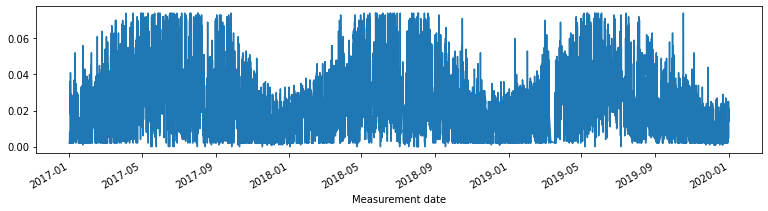

In [22]:
Ozone.plot(figsize=(13,3), legend=False)

plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


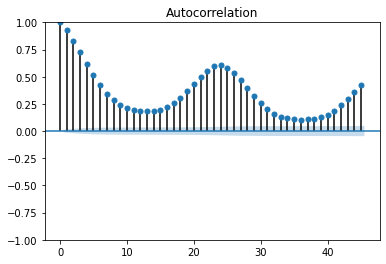

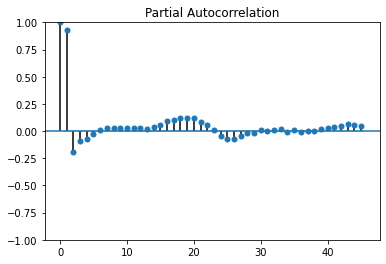

In [23]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(Ozone.O3)
plot_pacf(Ozone.O3)
plt.show()

In [24]:
inputO3=np.log(Ozone.O3.values)
logO3= inputO3[np.isfinite(inputO3)]
Ozone=Ozone[np.isfinite(inputO3)]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


<Figure size 936x216 with 0 Axes>

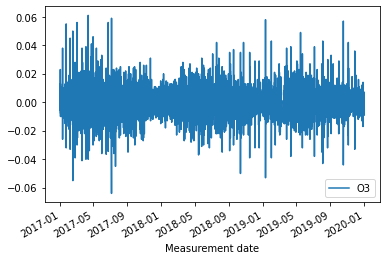

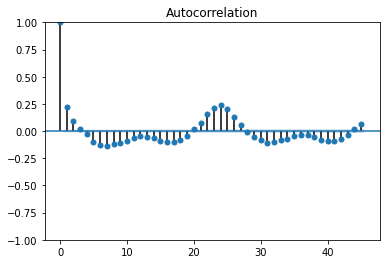

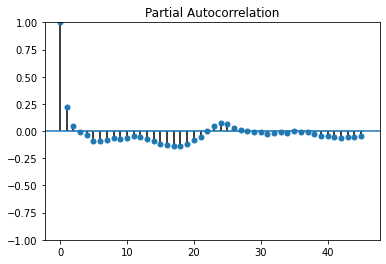

In [25]:
from pmdarima.arima import ndiffs

periods=1
diff_1=Ozone.diff(periods=periods).iloc[periods:]
plt.figure(figsize=(13,3))
diff_1.plot()
# plt.title(r'$\Delta O_{3}$ ('+st_name+')')

plot_acf(diff_1)
plot_pacf(diff_1)
plt.show()




In [38]:
# 자꾸 커널 죽,,ㅠ
import pmdarima as pm

from pmdarima import auto_arima
stepwise_model= auto_arima(logO3,start_p=1, start_q=1, max_p=3, max_q=3, m=1,
                           start_P=0, seasonal= False, d=1, D=1, trace=True, error_action='ignore', stepwise= True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=22066.881, Time=5.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=23062.056, Time=3.52 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=22100.031, Time=2.38 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=22065.119, Time=9.86 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=23060.057, Time=0.50 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=22066.865, Time=5.00 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=22068.985, Time=7.71 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=22063.119, Time=1.52 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=22064.881, Time=1.98 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=22064.865, Time=2.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=22098.031, Time=0.68 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=22066.986, Time=3.25 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 43.565 seconds


In [26]:
# from statsmodels.tsa.statespace.sarimax import SARIMAX
# #SARIMAX?
# srm= SARIMAX(logO3, order=(2,1,0), seasonal_order=(2,1,0,12)).fit(dis=-1)
# #p (time lag. of AR),d (time lag. of MA),q(difference 차수)
# #srm_fit = srm.fit(trend='nc', full_output=True, disp=True) ## trend option| nc: not continuous c: continuous

# print(srm.summary())


/usr/local/lib/python3.7/dist-packages/statsmodels/base/optimizer.py:23: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: dis. After release 0.14, this will raise.
  FutureWarning


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                25865
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 12)   Log Likelihood              -13970.925
Date:                            Sun, 30 Oct 2022   AIC                          27951.850
Time:                                    21:03:51   BIC                          27992.651
Sample:                                         0   HQIC                         27965.035
                                          - 25865                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1298      0.004     33.838      0.000       0.122       0.137
ar.L2         -0.0561      0.005   

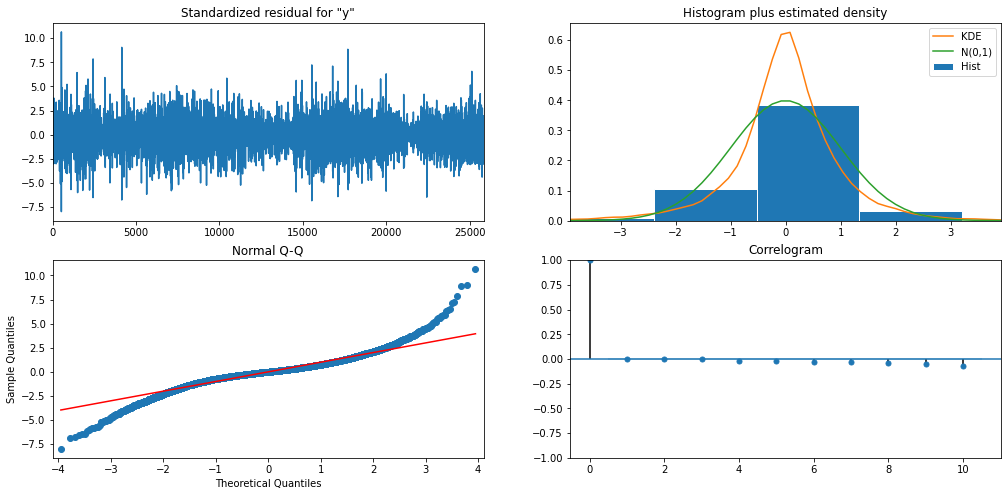

In [31]:
srm.plot_diagnostics(figsize=(17,8))
plt.tight_layout
plt.savefig('./result_sarima')
plt.show()

In [39]:
from statsmodels.tsa.arima.model import ARIMA


arm= ARIMA(logO3, order=(0,1,1))#p (time lag. of AR),d (time lag. of MA),q(difference 차수)
arm_fit = arm.fit() ## trend option| nc: not continuous c: continuous
print(arm_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                25865
Model:                 ARIMA(0, 1, 1)   Log Likelihood              -11029.560
Date:                Sun, 30 Oct 2022   AIC                          22063.119
Time:                        21:15:37   BIC                          22079.440
Sample:                             0   HQIC                         22068.393
                              - 25865                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1978      0.003     60.636      0.000       0.191       0.204
sigma2         0.1374      0.001    240.973      0.000       0.136       0.138
Ljung-Box (L1) (Q):                   0.01   Jarque-

In [49]:
srm_pred= srm.predict(typ='levels')

25865


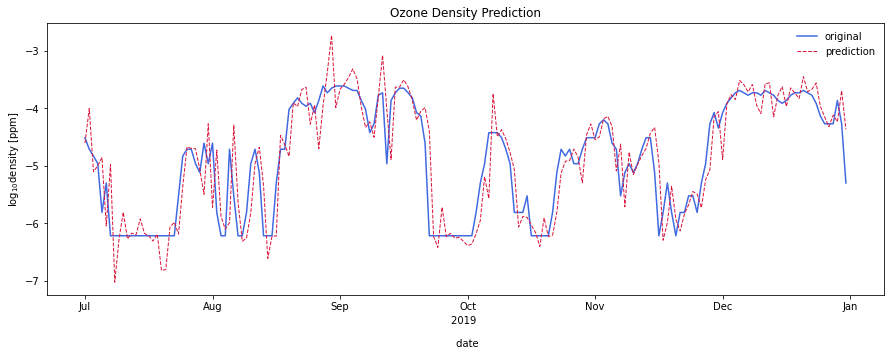

In [51]:
numo3= len(Ozone.O3)
print(numo3)
# tickname=(np.arange(0,4)*round(numo3/3))
# ticklabels=np.array(['2017','2018','2019','2020'])
tickname=np.arange(0,7)*round(180/6)
ticklabels=np.array(['Jul','Aug','Sep','Oct','Nov','Dec','Jan'])

plt.figure(figsize=(15,5))

fig=plt.plot(logO3[-180:], label='original', c='royalblue')
plt.plot(srm_pred[-180:], label='prediction', c='crimson', ls='--', lw=1)

plt.title('Ozone Density Prediction')
# plt.xlabel('date')
plt.xlabel('2019 \n\n date')
plt.ylabel('log$_{10}$density [ppm]')
plt.legend(frameon=False)
plt.xticks(ticks=tickname,labels=ticklabels)
plt.ylim()

plt.savefig('./prediction_SARIMA.png')

plt.show()

In [58]:
def scoring(true, pred):
  r2= round(metrics.r2_score(true, pred),3)
  corr= round(np.corrcoef(true, pred)[0,1],3) 
  mape= round(metrics.mean_absolute_percentage_error(true, pred)*100,3)
  rmse= round(metrics.mean_squared_error(true, pred, squared=False),3)
  acc= round(metrics.explained_variance_score(true, pred),3)
  mae= np.mean(np.abs(true-pred))
  
  df= pd.DataFrame({ "R2":   r2,
                     "Corr": corr,
                     "RMSE": rmse,
                     "MAPE": mape,
                     "MAE": mae,
                     "Accuracy": acc},
                     
                    index=[0])
  return df
  
scoring(logO3,srm_pred)


,R2,Corr,RMSE,MAPE,MAE,Accuracy
0,0.832,0.919,0.418,6.807,0.283482,0.832


In [41]:

arm_pred= arm_fit.predict(typ='levels')

25865


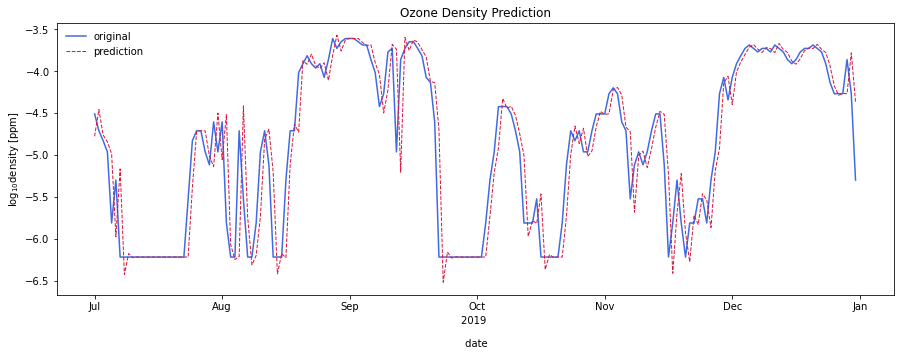

In [54]:
numo3= len(Ozone.O3)
print(numo3)
# tickname=(np.arange(0,4)*round(numo3/3))
# ticklabels=np.array(['2017','2018','2019','2020'])
tickname=np.arange(0,7)*round(180/6)
ticklabels=np.array(['Jul','Aug','Sep','Oct','Nov','Dec','Jan'])

plt.figure(figsize=(15,5))

fig=plt.plot(logO3[-180:], label='original', c='royalblue')
plt.plot(arm_pred[-180:], label='prediction', c='crimson', ls='--', lw=1)

plt.title('Ozone Density Prediction')
# plt.xlabel('date')
plt.xlabel('2019 \n\n date')
plt.ylabel('log$_{10}$density [ppm]')
plt.legend(frameon=False)
plt.xticks(ticks=tickname,labels=ticklabels)


plt.savefig('./prediction_ARIMA.png')

plt.show()

In [55]:
scoring(logO3,arm_pred)


,R2,Corr,RMSE,MAPE,MAE,Accuracy
0,0.866,0.934,0.373,5.491,0.232066,0.866
